In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import librosa
import numpy as np
import os
import re

In [26]:
class VideoProcessor:
    def __init__(self, file_name, transcript_file_path, aus_file_path, audio_file_path):
        self.file_name = file_name
        self.transcript_file_path = transcript_file_path
        self.aus_file_path = aus_file_path
        self.audio_file_path = audio_file_path
        self.df_transcript = None
        self.participant_intervals = None
        self.df_aus = None
        self.combined_result = None
        self.audio_data = None
        self.sample_rate = None
        self.spectrogram = None
        self.mel_spectrogram_df = None
        self.mfcc = None
        self.video_audio = None
        self.hop_lengths_list=[]
    
    def process_transcript(self, delimiter='\t'):
        """
        Processes the transcript file: loads it, converts the time columns to float,
        filters by speaker 'Participant', and displays the first few records.
        """
        # Load the transcript file
        self.df_transcript = pd.read_csv(self.transcript_file_path, delimiter=delimiter)
        
        # Convert 'start_time' and 'stop_time' columns to float type
        self.df_transcript['start_time'] = self.df_transcript["start_time"].astype(float)
        self.df_transcript['stop_time'] = self.df_transcript["stop_time"].astype(float)
        
        # Filter the DataFrame to include only rows where the speaker is 'Participant'
        self.participant_intervals = self.df_transcript[self.df_transcript["speaker"] == "Participant"]

    def preprocess_aus(self, df):
        """
        Preprocesses the aus DataFrame by cleaning column names and scaling AU features.

        This function performs the following steps:
        1. Removes leading spaces from column names.
        2. Selects columns containing specific AU features.
        3. Scales the selected columns using MinMaxScaler.
        4. Combines the timestamp column with the scaled data.

        Args:
            df (pd.DataFrame): Input DataFrame from OpenFace with AU feature columns.

        Returns:
            pd.DataFrame: New DataFrame with cleaned and scaled AU feature columns along with the timestamp.
        """
        # Clean column names
        df.columns = df.columns.str.strip().str.replace(' ', '')

        # Extract the timestamp column
        timestamp_column = df['timestamp']

        # Define the prefix and suffix for selecting AU feature columns
        au_prefix = 'AU'
        au_suffix = '_r'

        # Select AU feature columns
        au_columns = df.filter(like=au_prefix).filter(like=au_suffix)

        # Remove the suffix from AU column names
        au_columns.columns = au_columns.columns.str.replace(au_suffix, '')

        # Concatenate the timestamp column with the unscaled AU data
        preprocessed_aus = pd.concat([timestamp_column, au_columns], axis=1)

        return preprocessed_aus

    def process_aus(self):
        """
        Loads and preprocesses the Action Units (AU) data.
        
        This function performs the following steps:
        1. Loads the AU data from a text file.
        2. Preprocesses the AU data using the preprocess_aus function.
        3. Prints the shape of the processed AU DataFrame.
        4. Displays the first few rows of the processed AU DataFrame.
        """
        # Load the AUs file
        self.df_aus = pd.read_csv(self.aus_file_path)
        
        # Preprocess the AUs data using the preprocess_aus method
        self.df_aus = self.preprocess_aus(self.df_aus)

    def combine_and_filter_data(self):
        """
        Combines the AU and transcript DataFrames based on the timestamp values
        and filters the combined DataFrame to include rows where the timestamp
        is within the start and stop times.
        """
        # Ensure that the necessary DataFrames are loaded
        if self.df_aus is None or self.participant_intervals is None:
            raise ValueError("Los DataFrames de AUs y transcripción deben estar cargados y preprocesados.")
        
        # Combine the DataFrames based on timestamp values
        self.combined_result = pd.merge_asof(self.df_aus, self.participant_intervals, left_on="timestamp", right_on="start_time")
        
        # Filter the combined DataFrame to include rows where the timestamp is within the start and stop times
        self.combined_result = self.combined_result[
            (self.combined_result["timestamp"] >= self.combined_result["start_time"]) & 
            (self.combined_result["timestamp"] <= self.combined_result["stop_time"])
        ]
        
    def load_audio(self):
        """
        Loads the audio file and prints the sample rate and the shape of the audio data.
        """
        # Load the audio file
        self.audio_data, self.sample_rate = librosa.load(self.audio_file_path, sr=None)        

    def calculate_spectrogram(self):
        """
        Calculates the spectrogram of the audio data and adjusts it to match the desired number of frames.
        """
        # Ensure that audio data and the combined DataFrame are available
        if self.audio_data is None or self.combined_result is None:
            raise ValueError("Los datos de audio y el DataFrame combinado deben estar disponibles antes de calcular el espectrograma.")
        
        # Initial parameters
        n_fft = 1024  # Número de puntos FFT para el cálculo del espectrograma
        desired_num_frames = self.combined_result.shape[0]
        len_y = len(self.audio_data)
        
        # Print the desired number of frames and the format of the audio data
        # print(f'Desired number of frames: {desired_num_frames}')
        # print(f'Shape of audio data: {self.audio_data.shape}')
        
        # Calculate the hop length to achieve the desired number of frames
        hop_length = len_y // desired_num_frames
        
        # Calculate the current number of frames with this hop length
        num_frames_actual = (len_y - n_fft) // hop_length + 1
        # print(f'Actual number of frames: {num_frames_actual}')
        
        # Adjust the signal to match the desired number of frames
        if num_frames_actual < desired_num_frames:
            # Add padding if there are fewer frames than desired
            padding_needed = (desired_num_frames - num_frames_actual) * hop_length
            y_adjusted = np.pad(self.audio_data, (0, padding_needed), mode='constant')
        elif num_frames_actual > desired_num_frames:
            # Trim the signal if there are more frames than desired
            excess_samples = (num_frames_actual - desired_num_frames) * hop_length
            y_adjusted = self.audio_data[:-excess_samples]
        else:
            # Use the original signal if the number of frames already matches
            y_adjusted = self.audio_data
        
        # Calculate the spectrogram using librosa
        spectrogram_librosa = np.abs(librosa.stft(y_adjusted, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
        
        # Check the number of frames in the spectrogram
        actual_num_frames = spectrogram_librosa.shape[1]
        
        # Adjust if there is a small discrepancy in the number of frames
        if actual_num_frames < desired_num_frames:
            # Add padding to the adjusted signal to match the desired number of frames
            samples_needed = (desired_num_frames - actual_num_frames) * hop_length
            y_adjusted = np.pad(y_adjusted, (0, samples_needed), mode='constant')
            spectrogram_librosa = np.abs(librosa.stft(y_adjusted, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
        elif actual_num_frames > desired_num_frames:
            # Trim the adjusted signal to match the desired number of frames
            samples_to_trim = (actual_num_frames - desired_num_frames) * hop_length
            y_adjusted = y_adjusted[:-samples_to_trim]
            spectrogram_librosa = np.abs(librosa.stft(y_adjusted, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
        
        # Store the calculated spectrogram
        self.spectrogram = spectrogram_librosa
        # Show final spectogram
        # print("The shape of spectrogram_librosa is:", self.spectrogram.shape)
        # print("Expected number of frames:", desired_num_frames)
        # print("Actual number of frames:", self.spectrogram.shape[1])

        # MFCC
        mfcc = librosa.feature.mfcc(y=y_adjusted, sr=self.sample_rate, n_mfcc=60, hop_length=hop_length, n_fft=n_fft, window='hann')
        mfcc_df = pd.DataFrame(mfcc.T)
        self.mfcc = mfcc_df
        #mfcc_df.to_csv(f'../Results/Final/Audio_features/{self.file_name}_mfcc.csv', index=False)

        # Mel Spectrogram
        # Parameters for the Mel spectrogram
        mel_bins = 60  # Number of Mel bands
        fmin = 0       # Minimum frequency
        fmax = None    # Maximum frequency (None to use Nyquist frequency)

        # Calculate the Mel spectrogram
        Mel_spectrogram = librosa.feature.melspectrogram(
            y=y_adjusted,             # Adjusted audio signal
            sr=self.sample_rate,           # Sample rate of the audio
            n_fft=n_fft,              # FFT window size
            hop_length=hop_length,    # Hop length
            win_length=n_fft,         # Window length
            window='hann',            # Window function
            n_mels=mel_bins,          # Number of Mel bands
            power=2.0                 # Exponent for the magnitude
        )

        # Print the shape of the Mel spectrogram
        #print("The shape of Mel spectrogram is:", Mel_spectrogram.shape)
        #print("Hop length:", hop_length)

        # Convert the Mel spectrogram to a logarithmic scale (dB)
        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)

        # Convert to df and save it 
        mel_spectrogram_df = pd.DataFrame(mel_spectrogram_db.T)
        self.mel_spectrogram_df = mel_spectrogram_df

        # Print the shape of the log Mel spectrogram
        #print("The shape of Log Mel spectrogram is:", mel_spectrogram_db.shape)

        # Plot both spectrograms in subplots
        #plt.figure(figsize=(12, 8))

        # Plot 2: Log Mel spectrogram
        #librosa.display.specshow(
        #    mel_spectrogram_db,       # Log Mel spectrogram data
        #    sr=self.sample_rate,           # Sample rate
        #    x_axis='time',            # X-axis type
        #    y_axis='mel',             # Y-axis type
        #    hop_length=hop_length,    # Hop length
        #    fmin=fmin,                # Minimum frequency
        #    fmax=fmax                 # Maximum frequency
        #)
        #plt.colorbar(format='%+2.0f dB')  # Add color bar with dB scale
        #plt.title('Log Mel spectrogram')  # Title of the plot

        #plt.tight_layout()  # Adjust subplot parameters to give specified padding
        #plt.show()         # Display the plot
        if hop_length < 534:
            return hop_length
        
    def concatena_audio_visual(self):
        
        video_audio = pd.concat([self.combined_result.reset_index(drop=True), self.mfcc.reset_index(drop=True)], axis=1)
        self.video_audio = video_audio

        # Save
        #video_audio.to_csv(f'../Results/Final/Video_Audio_features/{self.file_name}_video_audio.csv', index=False)

        # Print the shape of the concatenated DataFrame
        print("Shape of concatenated DataFrame:", video_audio.shape)

        # Display the first few rows of the concatenated DataFrame
        #print(video_audio.head())



# Uso de la clase
processor = VideoProcessor('315','../Data/315_P/315_TRANSCRIPT.csv', '../Data/315_P/315_CLNF_AUs.txt', '../Results/Final/Noise_kept/audio/315.wav')
processor.process_transcript()
processor.process_aus()
processor.combine_and_filter_data()
processor.load_audio()
hop_length=processor.calculate_spectrogram()
processor.concatena_audio_visual()

Shape of concatenated DataFrame: (14201, 79)


In [32]:
data = '../Results/Final'
audio_folder = '../Results/Final/noise_kept_all/audio'

hop_lengths_list = []

for root, dirs, files in os.walk(audio_folder):
    for file in files:
        audio_path = os.path.join(root, file)
        file_name = re.search(r'\d+', file).group()
        transcript_path = os.path.join(data, f'Transcripts/{file_name}_TRANSCRIPT.csv')
        aus_path = os.path.join(data, f'AUs/{file_name}_CLNF_AUs.txt')
        processor = VideoProcessor(file_name, transcript_path, aus_path, audio_path)
        processor.process_transcript()
        processor.process_aus()
        processor.combine_and_filter_data()
        processor.load_audio()
        hop_length= processor.calculate_spectrogram()
        processor.concatena_audio_visual()
        if hop_length is not None:
            hop_lengths_list.append(hop_length)
        print(f'Processed {file_name}.')
        print('-'*100)


Shape of concatenated DataFrame: (4671, 79)
Processed 300.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (14269, 79)
Processed 301.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (6274, 79)
Processed 302.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (19294, 79)
Processed 303.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (10889, 79)
Processed 304.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (33559, 79)
Processed 305.
----------------------------------------------------------------------------------------------------
Shape of concatenated DataFrame: (15

## Hop length statistics

Value: 531, Count: 8
Value: 532, Count: 138
Value: 533, Count: 36


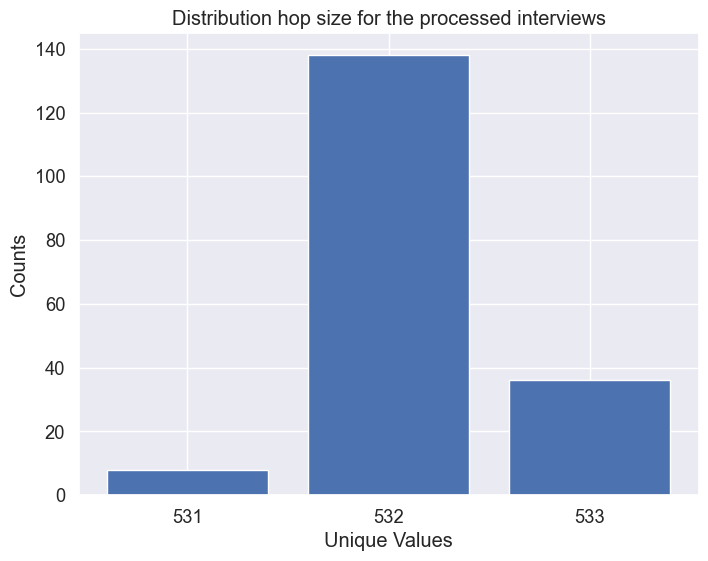

In [45]:
import seaborn as sns
sns.set_theme(font_scale=1.2)
hop_lengths_list = np.array(hop_lengths_list)
# Count the number of occurrences of each unique value in the list
unique_values, counts = np.unique(hop_lengths_list, return_counts=True)

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f'Value: {value}, Count: {count}')

plt.figure(figsize=(8, 6))
plt.bar(unique_values, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Distribution hop size for the processed interviews')

plt.xticks(unique_values)

# Mostrar el gráfico
plt.show()